# Telescope ansatz


In [1]:
import functools

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import polars as pl
import tqdm
from rich.pretty import pprint

from squint.circuit import Circuit
from squint.ops.fock import LinearOpticalUnitaryGate, FockState, Phase
from squint.utils import print_nonzero_entries

jax.config.update("jax_enable_x64", True)

In [ ]:
cut = 4
circuit = Circuit()

m = 3

# we add in the stellar photon, which is in an even superposition of spatial modes 0 and 2 (left and right telescopes)
circuit.add(
    FockState(
        wires=(
            0,
            m,
        ),
        n=[(1 / jnp.sqrt(2).item(), (1, 0)), (1 / jnp.sqrt(2).item(), (0, 1))],
    )
)
circuit.add(FockState(wires=(1,), n=(2,)))
for i in range(2 * m):
    if i in (0, 1, m):
        continue
    circuit.add(FockState(wires=(i,), n=[(1.0, (0,))]))


circuit.add(Phase(wires=(0,), phi=0.01), "phase")


circuit.add(
    LinearOpticalUnitaryGate(
        wires=tuple(list(range(1, m)) + list(range(m + 1, 2 * m))),
        rs=jnp.ones(m * (m - 1) // 2) * 0.1,
    )
)

circuit.add(LinearOpticalUnitaryGate(wires=tuple(range(0, m)), rs=jnp.ones(m * (m - 1) // 2) * 0.1))
circuit.add(LinearOpticalUnitaryGate(wires=tuple(range(m, 2 * m)), rs=jnp.ones(m * (m - 1) // 2) * 0.1))


# params, static = partition_op(circuit, "phase")
params, static = eqx.partition(circuit, eqx.is_inexact_array)
sim = circuit.compile(params, static, dim=cut, optimize="greedy")  # .jit()
get = lambda pytree: jnp.array([pytree.ops["phase"].phi])
pprint(circuit)

Circuit(
  ops={
│   0:
│   FockState(
│     wires=(0, 3),
│     n=[(0.7071067811865475, (1, 0)), (0.7071067811865475, (0, 1))]
│   ),
│   1:
│   FockState(wires=(1,), n=[(1.0, (2,))]),
│   2:
│   FockState(wires=(2,), n=[(1.0, (0,))]),
│   3:
│   FockState(wires=(4,), n=[(1.0, (0,))]),
│   4:
│   FockState(wires=(5,), n=[(1.0, (0,))]),
│   'phase':
│   Phase(wires=(0,), phi=weak_f64[]),
│   6:
│   LOPC(wires=(1, 2, 4, 5), rs=f64[3]),
│   7:
│   LOPC(wires=(0, 1, 2), rs=f64[3]),
│   8:
│   LOPC(wires=(3, 4, 5), rs=f64[3])
  },
  _backend='unitary'
)

In [3]:
# ket = sim.amplitudes.grad(params)
prob = sim.prob.forward(params)
# grad = sim.prob.grad(params)
print_nonzero_entries(prob)

Basis: [0 0 0 0 0 3], Value: 1.4019151421962306e-06
Basis: [0 0 0 0 1 2], Value: 4.2057463360833935e-06
Basis: [0 0 0 0 2 1], Value: 4.205745426588692e-06
Basis: [0 0 0 0 3 0], Value: 1.4019151421962306e-06
Basis: [0 0 0 1 0 2], Value: 4.24852260039188e-05
Basis: [0 0 0 1 1 1], Value: 8.497047383571044e-05
Basis: [0 0 0 1 2 0], Value: 4.24852260039188e-05
Basis: [0 0 0 2 0 1], Value: 7.3262222031189594e-06
Basis: [0 0 0 2 1 0], Value: 7.3262222031189594e-06
Basis: [0 0 0 3 0 0], Value: 2.2713793157436157e-07
Basis: [0 0 1 0 0 2], Value: 1.1627681487880182e-05
Basis: [0 0 1 0 1 1], Value: 2.3255357518792152e-05
Basis: [0 0 1 0 2 0], Value: 1.1627681487880182e-05
Basis: [0 0 1 1 0 1], Value: 0.00034557085018604994
Basis: [0 0 1 1 1 0], Value: 0.00034557085018604994
Basis: [0 0 1 2 0 0], Value: 2.9475073461071588e-05
Basis: [0 0 2 0 0 1], Value: 2.9655233447556384e-05
Basis: [0 0 2 0 1 0], Value: 2.9655233447556384e-05
Basis: [0 0 2 1 0 0], Value: 0.00070255744503811
Basis: [0 0 3 0 0 0],

In [ ]:
# %% Differentiate with respect to parameters of interest
def _loss_fn(params, sim, get):
    return sim.prob.cfim(get, params).squeeze()


loss_fn = functools.partial(_loss_fn, sim=sim, get=get)
print(f"Classical Fisher information of starting parameterization is {loss_fn(params)}")

# %%
start_learning_rate = 1e-2
optimizer = optax.chain(optax.adam(start_learning_rate), optax.scale(-1.0))
opt_state = optimizer.init(params)

Training: 100%|██████████| 300/300 [00:24<00:00, 12.05it/s, loss=0.5265788537476731]
/var/folders/fk/gsbw4p3n6wxb9cs3bj47j0p00000gn/T/ipykernel_62148/2143595474.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Basis: [0 0 0 5], Value: 0.012792176567018032
Basis: [0 0 1 4], Value: 1.525968764326535e-05
Basis: [0 0 2 3], Value: 0.008362630382180214
Basis: [0 0 3 2], Value: 0.007809266448020935
Basis: [0 0 4 1], Value: 0.0020920352544635534
Basis: [0 0 5 0], Value: 0.000178015063283965
Basis: [0 1 0 4], Value: 0.04510193318128586
Basis: [0 1 1 3], Value: 0.0053116572089493275
Basis: [0 1 2 2], Value: 0.035423777997493744
Basis: [0 1 3 1], Value: 0.0186296459287405
Basis: [0 1 4 0], Value: 0.0023545094300061464
Basis: [0 2 0 3], Value: 0.0713447704911232
Basis: [0 2 1 2], Value: 0.029452605172991753
Basis: [0 2 2 1], Value: 0.049033306539058685
Basis: [0 2 3 0], Value: 0.01108286902308464
Basis: [0 3 0 2], Value: 0.07134505361318588
Basis: [0 3 1 1], Value: 0.043031591922044754
Basis: [0 3 2 0], Value: 0.021972186863422394
Basis: [0 4 0 1], Value: 0.04510274901986122
Basis: [0 4 1 0], Value: 0.01887539029121399
Basis: [0 5 0 0], Value: 0.0127926766872406
Basis: [1 0 0 4], Value: 0.01887471042573

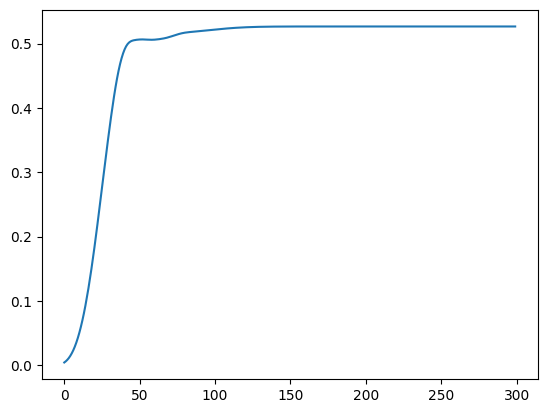

In [ ]:
# %%
@jax.jit
def update(_params, _opt_state):
    _val, _grad = jax.value_and_grad(loss_fn)(_params)
    _updates, _opt_state = optimizer.update(_grad, _opt_state)
    _params = optax.apply_updates(_params, _updates)
    return _params, _opt_state, _val


# %%
df = []
update(params, opt_state)
n_steps = 300
pbar = tqdm.tqdm(range(n_steps), desc="Training", unit="it")
for step in pbar:
    params, opt_state, val = update(params, opt_state)

    pbar.set_postfix({"loss": val})
    pbar.update(1)

    df.append({"cfim": val, "step": step})

df = pl.DataFrame(df)

# %%
fig, ax = plt.subplots()
ax.plot(df["step"], df["cfim"])
fig.show()

# %%
prob = sim.prob.forward(params)
print_nonzero_entries(prob)
eqx.tree_pprint(params, short_arrays=False)

In [6]:
# # we next compute the classical Fisher information
# cfi = jnp.sum(get(grad)**2 / (prob + 1e-14))
# print(f"The classical Fisher information for `phi` is {cfi}")

# # this can also be performed from the `sim` object
# cfim = sim.prob.cfim(get, params)
# print(f"The classical Fisher information is {cfim}")

In [7]:
# phis = jnp.linspace(-jnp.pi, jnp.pi, 100)
# params = eqx.tree_at(
#     lambda pytree: pytree.ops["phase"].phi, params, jnp.expand_dims(phis, axis=1)
# )

# probs = eqx.filter_vmap(sim.prob.forward)(params)


In [8]:
# colors = cycle(sns.color_palette(n_colors=jnp.prod(jnp.array(probs.shape[1:]))))
# styles = cycle(['--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted'])
# fig, ax = plt.subplots()
# for i, idx in enumerate(
#     itertools.product(*[list(range(ell)) for ell in probs.shape[1:]])
# ):
#     if jnp.mean(probs[:, *idx]) < 1e-6:
#         continue
#     label = f"{idx}" if jnp.mean(probs[:, *idx]) > 1e-6 else None
#     # print(label, jnp.mean(probs[:, *idx]))
#     ax.plot(phis, probs[:, *idx], label=label, color=next(colors), ls=next(styles), alpha=0.8)
# ax.legend()
# ax.set(xlabel=r"Phase, $\varphi$", ylabel=r"Probability, $p(\mathbf{x} | \varphi)$")
